In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pysilsub.problems import SilentSubstitutionProblem as SSP
from pysilsub.CIE import get_CIES026_action_spectra

In [4]:
# Functions for stimulus waveform
def get_time_vector(duration):
    t = np.arange(0, (duration*1000), 10).astype("int")
    return t


def sinusoid_modulation(f, duration, Fs=50):
    x = np.arange(duration * Fs)
    sm = np.sin(2 * np.pi * f * x / Fs)
    return sm


def modulate_intensity_amplitude(sm, background, amplitude):
    ivals = (background + (sm*amplitude)).astype("int")
    return ivals

In [5]:
# Load the calibration data
spds = pd.read_csv(
    '../data/BCGAR_5_Primary_8_bit_linear.csv', 
    index_col=['Primary','Setting'])
spds.columns = pd.Int64Index(spds.columns.astype(int))
spds.columns.name = 'Wavelength'

# List of colors for the primaries
colors = ['blue', 'cyan', 'green', 'orange', 'red'] 


ssp = SSP(
    resolutions=[255]*5,  # Five 8-bit primaries 
    colors=colors,  # Colors of the LEDs
    spds=spds,  # The calibration data
    wavelengths=[380, 781, 1],  # SPD wavelength binwidth
    ignore=['R'],  # Ignore rods
    silence=['M', 'L', 'I'],  # Silence S-, M-, and L-cones
    isolate=['S'],  # Isolate melanopsin
    target_contrast=2.,  # Aim for 250% contrast 
    name='BCGAR (8-bit, linear)',  # Description of device
    background=[.5]*5
) 

#spd_fig = ssp.plot_spds()

/var/folders/c9/7yddvl1n2ss863cgfngj0wpm0000gp/T/ipykernel_58055/1990463534.py:5: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  spds.columns = pd.Int64Index(spds.columns.astype(int))


TypeError: SilentSubstitutionProblem.__init__() got an unexpected keyword argument 'resolutions'

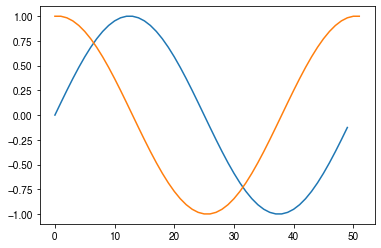

In [6]:
# Target contrast vals for modulation
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * 1.
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

S-cone contrast modulation
==========================

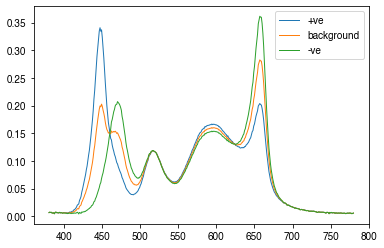

In [7]:
# Calcualte modulation spectra for S-cone modulation
contrast_mods = [ssp.linalg_solve([tc, 0, 0, 0]) for tc in target_contrasts]

plt.plot(ssp.predict_multiprimary_spd(contrast_mods[0]), lw=1, label='+ve')
plt.plot(ssp.predict_multiprimary_spd(ssp.background), lw=1, label='background')
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[-1]), lw=1, label='-ve')
plt.legend()


Modulation peak
---------------

In [ ]:
ssp.plot_ss_result(contrast_mods[0])
contrasts = ssp.get_photoreceptor_contrasts(contrast_mods[0])
print(f'S-cone contrast: {contrasts[0]}')
print(f'Splatter: {contrasts[1:]}')

Modulation trough
-----------------

In [ ]:
ssp.plot_ss_result(contrast_mods[-1])
contrasts = ssp.get_photoreceptor_contrasts(contrast_mods[-1])
print(f'S-cone contrast: {contrasts[0]}')
print(f'Splatter: {contrasts[1:]}')

Contrast modulations
--------------------

In [ ]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ssp.predict_multiprimary_spd(ssp.background)
for i, s in enumerate(contrast_mods):
    mod_spd = ssp.predict_multiprimary_spd(s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');

In [ ]:
splatter = [ssp.get_photoreceptor_contrasts(cm) for cm in contrast_mods]
splatter = np.vstack(splatter)

plt.plot(splatter[:,0], label='S', c='b')
plt.plot(splatter[:,1], label='M', c='g')
plt.plot(splatter[:,2], label='L', c='r')
plt.plot(splatter[:,3], label='R', c='k')
plt.plot(splatter[:,4], label='I', c='cyan')
plt.ylabel('Simple contrast')
plt.legend()

Melanopsin
----------

In [ ]:
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * .7
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

In [ ]:
ssp.isolate = ['I']
ssp.silence = ['S', 'M', 'L']

contrast_mods = [ssp.linalg_solve([0, 0, 0, tc]) for tc in target_contrasts]
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[0]), lw=1, label='+ve')
plt.plot(ssp.predict_multiprimary_spd(ssp.background), lw=1, label='background')
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[-1]), lw=1, label='-ve')
plt.legend()

In [ ]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ssp.predict_multiprimary_spd(ssp.background)
for i, s in enumerate(contrast_mods):
    mod_spd = ssp.predict_multiprimary_spd(s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');

In [ ]:
splatter = [ssp.get_photoreceptor_contrasts(cm) for cm in contrast_mods]
splatter = np.vstack(splatter)

plt.plot(splatter[:,0], label='S', c='b')
plt.plot(splatter[:,1], label='M', c='g')
plt.plot(splatter[:,2], label='L', c='r')
plt.plot(splatter[:,3], label='R', c='k')
plt.plot(splatter[:,4], label='I', c='cyan')
plt.ylabel('Simple contrast')
plt.legend()

M-cone
------

In [ ]:
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * .5
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

In [ ]:
ssp.isolate = ['M']
ssp.silence = ['S', 'L', 'I']

contrast_mods = [ssp.linalg_solve([0, tc, 0, 0]) for tc in target_contrasts]
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[0]), lw=1, label='+ve')
plt.plot(ssp.predict_multiprimary_spd(ssp.background), lw=1, label='background')
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[-1]), lw=1, label='-ve')
plt.legend()

In [ ]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ssp.predict_multiprimary_spd(ssp.background)
for i, s in enumerate(contrast_mods):
    mod_spd = ssp.predict_multiprimary_spd(s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');

In [ ]:
splatter = [ssp.get_photoreceptor_contrasts(cm) for cm in contrast_mods]
splatter = np.vstack(splatter)

plt.plot(splatter[:,0], label='S', c='b')
plt.plot(splatter[:,1], label='M', c='g')
plt.plot(splatter[:,2], label='L', c='r')
plt.plot(splatter[:,3], label='R', c='k')
plt.plot(splatter[:,4], label='I', c='cyan')
plt.ylabel('Simple contrast')
plt.legend()

L-cone
------

In [ ]:
contrast_waveform = sinusoid_modulation(f=1, duration=1, Fs=50) * 1.1
plt.plot(contrast_waveform)
peak = np.argmax(contrast_waveform)
trough = np.argmin(contrast_waveform)
target_contrasts = contrast_waveform[peak:trough+1]
plt.plot(np.hstack([target_contrasts, target_contrasts[::-1]]))

In [ ]:
ssp.isolate = ['L']
ssp.silence = ['S', 'M', 'I']

contrast_mods = [ssp.linalg_solve([0, 0, tc, 0]) for tc in target_contrasts]
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[0]), lw=1, label='+ve')
plt.plot(ssp.predict_multiprimary_spd(ssp.background), lw=1, label='background')
plt.plot(ssp.predict_multiprimary_spd(contrast_mods[-1]), lw=1, label='-ve')
plt.legend()

In [ ]:
palette = sns.diverging_palette(220, 20, n=len(contrast_mods), l=65, as_cmap=False)
bg_spd = ssp.predict_multiprimary_spd(ssp.background)
for i, s in enumerate(contrast_mods):
    mod_spd = ssp.predict_multiprimary_spd(s) 
    plt.plot(mod_spd-bg_spd, c=palette[i], lw=1)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('S-cone contrast (%)');

In [ ]:
splatter = [ssp.get_photoreceptor_contrasts(cm) for cm in contrast_mods]
splatter = np.vstack(splatter)

plt.plot(splatter[:,0], label='S', c='b')
plt.plot(splatter[:,1], label='M', c='g')
plt.plot(splatter[:,2], label='L', c='r')
plt.plot(splatter[:,3], label='R', c='k')
plt.plot(splatter[:,4], label='I', c='cyan')
plt.ylabel('Simple contrast')
plt.legend()